In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import copy
from collections import Counter
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

### Methods for experiment

In [3]:
def generate_random(orig_data, feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        low = np.min(orig_data[:, i])
        high = np.max(orig_data[:, i])
        df[feature_names[i]] = np.random.uniform(low=low, high=high, size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [4]:
def generate_random_without_constraints(feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        df[feature_names[i]] = np.random.normal(size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [5]:
def objective_function(array, label1, label2):
    return abs(1 - float(len(array[array == label1]))/len(array[array == label2]))

In [6]:
def create_summary(X, y, label0, label1, blackbox, epsilon=1e-2, verbose=False):
    
    n_features = X.shape[1]
    i = 1
    while objective_function(y, label0, label1) > epsilon:

        first_label = X[y == label0]
        second_label = X[y == label1]
        if len(first_label) > len(second_label):
            dist = second_label
            not_dist = first_label
        else:
            dist = first_label
            not_dist = second_label

        size = dist.shape[0]
        mean, std = np.mean(dist), np.std(dist)
        shape = np.abs(first_label.shape[0] - second_label.shape[0])
        rnd = np.random.normal(loc=mean, scale=std, size=[shape, n_features])
        X = np.vstack((dist, not_dist[:size, :], rnd[:(X.shape[0] - 2*size), :]))

        y = blackbox.predict(X)
        if verbose:
            print 'Epoch: {}\n'.format(i),Counter(y)
        i += 1
    return X

In [7]:
def perform_experiment(X, y, feature_names, blackbox, whitebox, verbose=False):
    
    " X and y corresponds to the training data and labels"
    
    ## Generating random data without constraints
    X_random = generate_random_without_constraints(feature_names, data_size=1000).values
    
    ## Fitting blackbox on the data and predicting labels for random data
    blackbox = copy.deepcopy(blackbox)
    blackbox.fit(X, y)
    if verbose:
        print 'Performance of black box on actual data', blackbox.score(X, y)
    y_random = blackbox.predict(X_random)
    if verbose:
        print 'Initial configuration of random labels: ', Counter(y_random)
    
    ## Whitebox performance on random data
    whitebox = copy.deepcopy(whitebox)
    whitebox.fit(X_random, y_random)
    old_score = whitebox.score(X, y)
    if verbose:
        print 'Performance of whitebox when trained using random data:', old_score
    
    ## Creating new data with equal proportion of both labels
    new_data = create_summary(X_random, y_random, 0, 1, blackbox, verbose=True)
    new_labels = blackbox.predict(new_data)
    if verbose:
        print 'Final configuration of random labels: ', Counter(new_labels)
    
    ## Whitebox performance using new data
    whitebox = copy.deepcopy(whitebox)
    whitebox.fit(new_data, new_labels)
    new_score = whitebox.score(X, y)
    if verbose:
        print 'Performance of whitebox when trained using new data:', new_score
    return old_score, new_score

### Breast Cancer Dataset

In [37]:
first_dataset = datasets.load_breast_cancer()
X = first_dataset.data
y = first_dataset.target
feature_names = ['feature{}'.format(i) for i in range(X.shape[1])]
print X.shape, y.shape

(569, 30) (569,)


In [38]:
print 'Characteristics of the Dataset: '
print 'Mean: ', np.mean(X)
print 'Standard Deviation: ', np.std(X)

Characteristics of the Dataset: 
Mean:  61.8907123395
Standard Deviation:  228.297405083


In [39]:
print 'Blackbox Accuracy: '
blackbox = LogisticRegression()
blackbox.fit(X, y)
print blackbox.score(X, y)

Blackbox Accuracy: 
0.959578207381


In [40]:
old_score, new_score = [],[]
for i in range(10):
    
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

Epoch: 1
Counter({1: 504, 0: 496})
Epoch: 2
Counter({1: 501, 0: 499})
Epoch: 1
Counter({1: 503, 0: 497})
Epoch: 2
Counter({0: 501, 1: 499})
Epoch: 1
Counter({0: 502, 1: 498})
Epoch: 1
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 506, 0: 494})
Epoch: 2
Counter({1: 502, 0: 498})
Epoch: 1
Counter({1: 502, 0: 498})
Epoch: 1
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 504, 0: 496})
Epoch: 2
Counter({0: 502, 1: 498})
Epoch: 1
Counter({1: 511, 0: 489})
Epoch: 2
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 506, 0: 494})
Epoch: 2
Counter({0: 502, 1: 498})


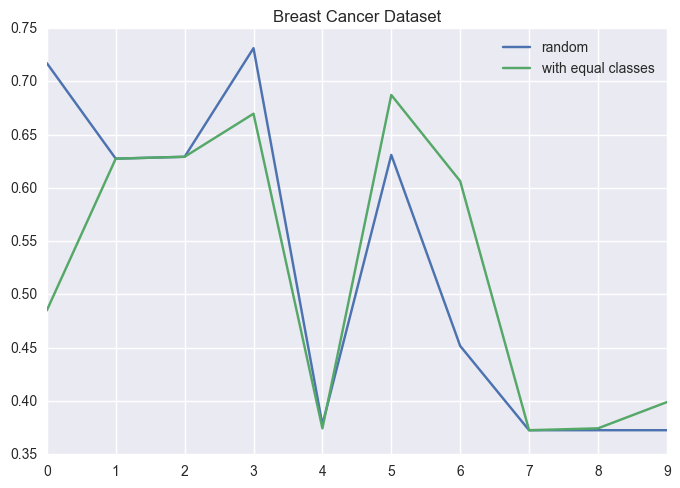

In [41]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes')
plt.title('Breast Cancer Dataset')
plt.legend()
plt.show()

In [42]:
print 'Random Dataset Score: ', old_score
print  np.mean(old_score)

Random Dataset Score:  [0.71704745166959583, 0.62741652021089633, 0.62917398945518455, 0.73110720562390163, 0.37785588752196836, 0.63093145869947276, 0.45166959578207383, 0.37258347978910367, 0.37258347978910367, 0.37258347978910367]
0.528295254833


In [14]:
print 'Equitable class random dataset score: ', new_score

Equitable class random dataset score:  [0.63620386643233739, 0.37785588752196836, 0.83479789103690683, 0.62741652021089633, 0.43585237258347981, 0.62741652021089633, 0.37434094903339193, 0.47275922671353249, 0.65905096660808438, 0.62741652021089633]


### Heart Dataset

In [48]:
second_dataset = pd.read_csv('../data/heart.csv')
y = second_dataset.pop('chd').values
second_dataset['famhist'] = second_dataset['famhist'].map({"Absent": 0, "Present": 1})
feature_names = second_dataset.columns
X = second_dataset.values
print X.shape, y.shape

(462, 9) (462,)


In [49]:
print 'Characteristics of the Dataset: '
print 'Mean: ', np.mean(X)
print 'Standard Deviation: ', np.std(X)

Characteristics of the Dataset: 
Mean:  34.6148388648
Standard Deviation:  42.2743469741


In [50]:
print 'Blackbox Accuracy: '
blackbox = LogisticRegression()
blackbox.fit(X, y)
print blackbox.score(X, y)

Blackbox Accuracy: 
0.733766233766


In [51]:
old_score, new_score = [],[]
for i in range(10):
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

Epoch: 1
Counter({0: 961, 1: 39})
Epoch: 2
Counter({0: 863, 1: 137})
Epoch: 3
Counter({0: 759, 1: 241})
Epoch: 4
Counter({0: 667, 1: 333})
Epoch: 5
Counter({0: 590, 1: 410})
Epoch: 6
Counter({0: 543, 1: 457})
Epoch: 7
Counter({0: 516, 1: 484})
Epoch: 8
Counter({0: 510, 1: 490})
Epoch: 9
Counter({0: 506, 1: 494})
Epoch: 10
Counter({0: 503, 1: 497})
Epoch: 11
Counter({0: 502, 1: 498})
Epoch: 1
Counter({0: 909, 1: 91})
Epoch: 2
Counter({0: 808, 1: 192})
Epoch: 3
Counter({0: 696, 1: 304})
Epoch: 4
Counter({0: 624, 1: 376})
Epoch: 5
Counter({0: 562, 1: 438})
Epoch: 6
Counter({0: 536, 1: 464})
Epoch: 7
Counter({0: 523, 1: 477})
Epoch: 8
Counter({0: 513, 1: 487})
Epoch: 9
Counter({0: 507, 1: 493})
Epoch: 10
Counter({0: 505, 1: 495})
Epoch: 11
Counter({0: 504, 1: 496})
Epoch: 12
Counter({0: 503, 1: 497})
Epoch: 13
Counter({0: 501, 1: 499})
Epoch: 1
Counter({0: 944, 1: 56})
Epoch: 2
Counter({0: 809, 1: 191})
Epoch: 3
Counter({0: 675, 1: 325})
Epoch: 4
Counter({0: 580, 1: 420})
Epoch: 5
Counter(

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

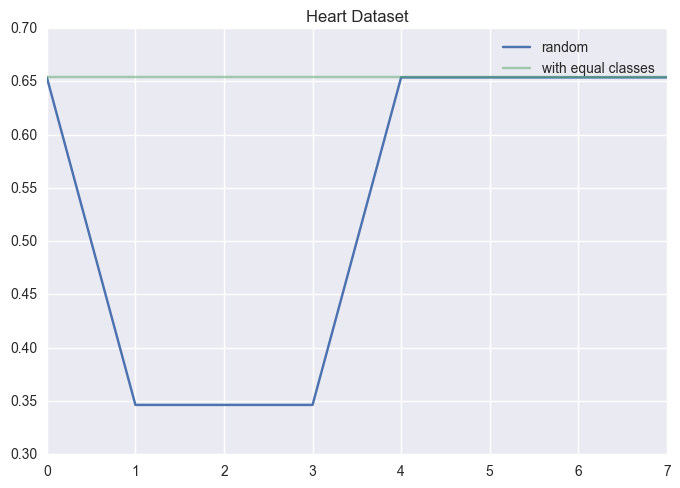

In [52]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes',alpha=0.5)
plt.title('Heart Dataset')
plt.legend()
plt.show()

In [53]:
print 'Random Dataset Score: ', old_score
print np.mean(old_score)

Random Dataset Score:  [0.65367965367965364, 0.34632034632034631, 0.34632034632034631, 0.34632034632034631, 0.65367965367965364, 0.65367965367965364, 0.65367965367965364, 0.65367965367965364]
0.53841991342


In [ ]:
print 'Equitable class random dataset score: ', new_score

### BUPA Dataset
http://www.cs.huji.ac.il/~shais/datasets/ClassificationDatasets.html

In [54]:
data = pd.read_csv('../data/bupa.data.txt', names=['feature{}'.format(i) for i in range(1,8)])
labels = pd.read_csv('../data/bupa.ascii.txt', names=['labels'])
labels['labels'] = labels['labels'].map({-1:0, 1:1})
X = data.values
y = labels['labels'].values
feature_names = data.columns
print X.shape, y.shape

(345, 7) (345,)


In [55]:
print 'Characteristics of the Dataset: '
print 'Mean: ', np.mean(X)
print 'Standard Deviation: ', np.std(X)

Characteristics of the Dataset: 
Mean:  36.9138716356
Standard Deviation:  35.5925009275


In [56]:
print 'Blackbox Accuracy: '
blackbox = LogisticRegression()
blackbox.fit(X, y)
print blackbox.score(X, y)

Blackbox Accuracy: 
0.585507246377


In [57]:
old_score, new_score = [],[]
for i in range(10):
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

Epoch: 1
Counter({0: 863, 1: 137})
Epoch: 2
Counter({0: 729, 1: 271})
Epoch: 3
Counter({0: 622, 1: 378})
Epoch: 4
Counter({0: 554, 1: 446})
Epoch: 5
Counter({0: 523, 1: 477})
Epoch: 6
Counter({0: 509, 1: 491})
Epoch: 7
Counter({0: 505, 1: 495})
Epoch: 8
Counter({0: 502, 1: 498})
Epoch: 1
Counter({0: 832, 1: 168})
Epoch: 2
Counter({0: 736, 1: 264})
Epoch: 3
Counter({0: 634, 1: 366})
Epoch: 4
Counter({0: 569, 1: 431})
Epoch: 5
Counter({0: 532, 1: 468})
Epoch: 6
Counter({0: 510, 1: 490})
Epoch: 7
Counter({0: 508, 1: 492})
Epoch: 8
Counter({0: 503, 1: 497})
Epoch: 9
Counter({0: 500, 1: 500})
Epoch: 1
Counter({0: 878, 1: 122})
Epoch: 2
Counter({0: 755, 1: 245})
Epoch: 3
Counter({0: 640, 1: 360})
Epoch: 4
Counter({0: 563, 1: 437})
Epoch: 5
Counter({0: 530, 1: 470})
Epoch: 6
Counter({0: 512, 1: 488})
Epoch: 7
Counter({0: 506, 1: 494})
Epoch: 8
Counter({0: 503, 1: 497})
Epoch: 9
Counter({0: 501, 1: 499})
Epoch: 1
Counter({0: 835, 1: 165})
Epoch: 2
Counter({0: 708, 1: 292})
Epoch: 3
Counter({0:

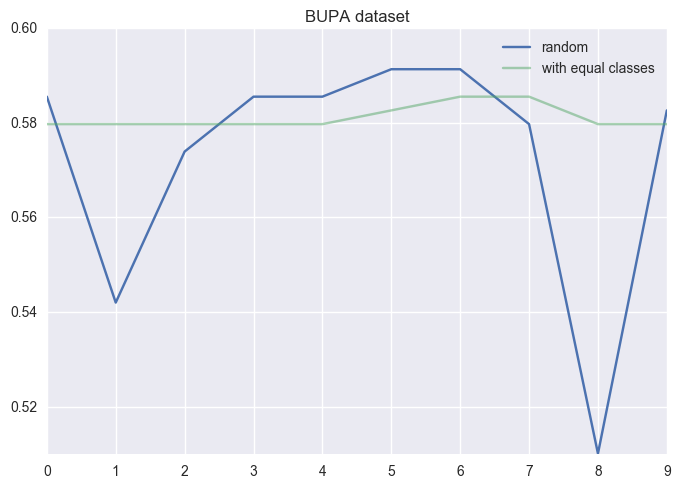

In [58]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes',alpha=0.5)
plt.title('BUPA dataset')
plt.legend()
plt.show()

In [59]:
print 'Random Dataset Score: ', old_score
print np.mean(old_score)

Random Dataset Score:  [0.58550724637681162, 0.54202898550724643, 0.57391304347826089, 0.58550724637681162, 0.58550724637681162, 0.59130434782608698, 0.59130434782608698, 0.57971014492753625, 0.51014492753623186, 0.58260869565217388]
0.572753623188


In [60]:
print 'Equitable class random dataset score: ', new_score

Equitable class random dataset score:  [0.57971014492753625, 0.57971014492753625, 0.57971014492753625, 0.57971014492753625, 0.57971014492753625, 0.58260869565217388, 0.58550724637681162, 0.58550724637681162, 0.57971014492753625, 0.57971014492753625]


### Halloween Dataset (from Kaggle)

In [29]:
data = pd.read_csv('../../../Dataset/Halloween/train.csv')
data = data[(data['type'] == 'Ghoul') | (data['type'] == 'Ghost')]
data['type'] = data['type'].map({"Ghoul":0, "Ghost":1})
mapping = {v:k for k,v in dict(enumerate(np.unique(data['color']))).iteritems()}
data['color'] = data['color'].map(mapping)
y = data.pop('type').values
X = data.values
feature_names = data.columns
print X.shape, y.shape

(246, 6) (246,)


In [30]:
print 'Characteristics of the Dataset: '
print 'Mean: ', np.mean(X)
print 'Standard Deviation: ', np.std(X)

Characteristics of the Dataset: 
Mean:  76.0565010544
Standard Deviation:  199.312178777


In [31]:
print 'Black Box Accuracy: '
blackbox = LogisticRegression()
blackbox.fit(X, y)
print blackbox.score(X, y)

Black Box Accuracy: 
0.951219512195


In [32]:
old_score, new_score = [],[]
for i in range(10):
    a, b = perform_experiment(X, y, feature_names, LogisticRegression(), LogisticRegression())
    old_score.append(a)
    new_score.append(b)

Epoch: 1
Counter({1: 537, 0: 463})
Epoch: 2
Counter({1: 512, 0: 488})
Epoch: 3
Counter({1: 502, 0: 498})
Epoch: 1
Counter({1: 527, 0: 473})
Epoch: 2
Counter({0: 504, 1: 496})
Epoch: 3
Counter({0: 501, 1: 499})
Epoch: 1
Counter({1: 519, 0: 481})
Epoch: 2
Counter({0: 505, 1: 495})
Epoch: 3
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 534, 0: 466})
Epoch: 2
Counter({1: 502, 0: 498})
Epoch: 1
Counter({1: 531, 0: 469})
Epoch: 2
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 517, 0: 483})
Epoch: 2
Counter({1: 503, 0: 497})
Epoch: 3
Counter({1: 501, 0: 499})
Epoch: 1
Counter({1: 530, 0: 470})
Epoch: 2
Counter({1: 504, 0: 496})
Epoch: 3
Counter({1: 503, 0: 497})
Epoch: 4
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 504, 0: 496})
Epoch: 2
Counter({1: 501, 0: 499})
Epoch: 1
Counter({1: 530, 0: 470})
Epoch: 2
Counter({1: 505, 0: 495})
Epoch: 3
Counter({0: 500, 1: 500})
Epoch: 1
Counter({1: 522, 0: 478})
Epoch: 2
Counter({1: 508, 0: 492})
Epoch: 3
Counter({1: 501, 0: 499})


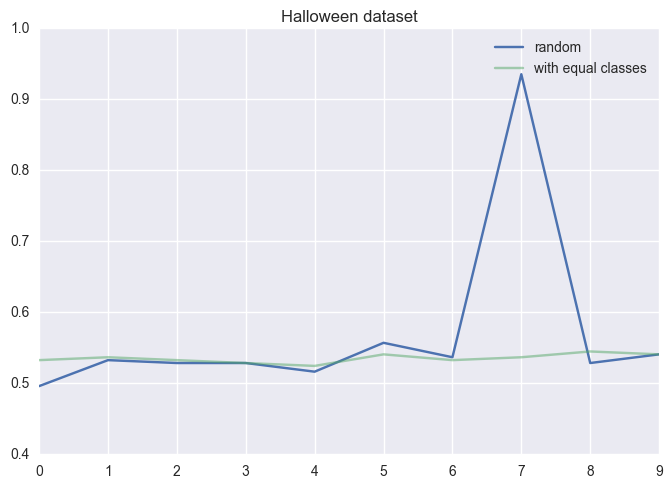

In [33]:
plt.plot(old_score, label='random')
plt.plot(new_score, label='with equal classes',alpha=0.5)
plt.title('Halloween dataset')
plt.legend()
plt.show()

In [34]:
X_random = generate_random(X, feature_names, data_size=1000)
y_random = blackbox.predict(X_random)
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print whitebox.score(X, y)

0.943089430894


In [35]:
print 'Random Dataset Score: ', old_score
print np.mean(old_score)

Random Dataset Score:  [0.49593495934959347, 0.53252032520325199, 0.52845528455284552, 0.52845528455284552, 0.51626016260162599, 0.55691056910569103, 0.53658536585365857, 0.93495934959349591, 0.52845528455284552, 0.54065040650406504]


In [36]:
print 'Equitable class random dataset score: ', new_score

Equitable class random dataset score:  [0.53252032520325199, 0.53658536585365857, 0.53252032520325199, 0.52845528455284552, 0.52439024390243905, 0.54065040650406504, 0.53252032520325199, 0.53658536585365857, 0.54471544715447151, 0.54065040650406504]
